In [1]:
from monitorlib import load_pcdata
import pandas as pd

def sync_positions(data,sample,i):
     # Searching for the cursor position that it is nearest to screenshot timestamp ti 
     # (before or after, it does not matter)
     ti = data[sample]['screenshots']['timestamp'][i]
     abs_diff = abs(data[sample]['moves']['timestamp'] - ti)
     closest_index = abs_diff.idxmin()
     px, py = data[sample]['moves']['px'][closest_index], data[sample]['moves']['py'][closest_index]
     return px, py

def sync_MKevents(sample_df, data, sample):
     
     def set_value(sample_df, tdiff, event, position=None):
          # Searching for the screenshot immediately before to the M&K event timestamp ti
          closest_index = abs(tdiff[tdiff <= 0]).idxmin()
          if sample_df['mouse_keyboard'][closest_index] != None:
               print('colision between M&K events', sample_df['mouse_keyboard'][closest_index], event)   # what to do?
               sample_df.loc[closest_index, 'mouse_keyboard'] = event
          else:
               sample_df.loc[closest_index, 'mouse_keyboard'] = event
          if position != None:
               sample_df.loc[closest_index, 'px'] = position[0]
               sample_df.loc[closest_index, 'py'] = position[1]
          
     # Initial values
     sample_df['mouse_keyboard'] = [None for i in range(len(sample_df))]
     timestamps_df = data[sample]['screenshots']['timestamp']

     # Clicks
     for i in range(len(data[sample]['clicks'])):
          ti = data[sample]['clicks']['timestamp'][i]
          button = data[sample]['clicks']['button'][i]
          click_px, click_py = data[sample]['clicks']['px'][i], data[sample]['clicks']['py'][i]
          set_value(sample_df, timestamps_df - ti, button, (click_px,click_py))

     # Scrolls
     for i in range(len(data[sample]['scrolls'])):
          ti = data[sample]['scrolls']['timestamp'][i]
          dy = data[sample]['scrolls']['dy'][i] 
          scroll_px, scroll_py = data[sample]['scrolls']['px'][i], data[sample]['scrolls']['py'][i]
          if dy == 1:
               scroll = 'scroll_down' 
          elif dy == -1:
               scroll = 'scroll_up'
          else:
               scroll = 'what?_scroll'
          set_value(sample_df, timestamps_df - ti, scroll, (scroll_px, scroll_py))
   
     # Keyboard events
     for i in range(len(data[sample]['keys'])):
          ti = data[sample]['keys']['timestamp'][i]
          key = data[sample]['keys']['key'][i].strip("'")
          set_value(sample_df, timestamps_df - ti, key)

def sync(data):
     samples = []
     for sample in data.keys():
          print(f'processing {sample}')
          sample_df = pd.DataFrame()
          sample_df['img_path'] = [img_path for img_path in data[sample]['screenshots']['img_path']]
          
          # Sync cursor positions to screenshots
          positions = [sync_positions(data,sample,i) for i in range(len(data[sample]['screenshots']))]
          sample_df['px'] = [px for px, _ in positions]
          sample_df['py'] = [py for _, py in positions]

          # Sync mouse and keyboard events to screenshots
          sync_MKevents(sample_df, data, sample)

          samples.append(sample_df)
     return samples

data = load_pcdata('data') 

# Syncronization. Order in time: 1) M&K Events, 2) Screenshoots and 3) Cursor positions 
samples = sync(data)

# Replace None values with a string
for sample in samples:
    sample.fillna("no_action",inplace=True)

# tokenization
tokens = set()
for sample in samples:
    tokens.update(sample['mouse_keyboard'].unique().tolist())
tokens = list(tokens)
tokens.sort()
print(len(tokens))
print(tokens)

# Add timestamp column
for sample in samples:
    sample['time'] = sample['img_path'].map(lambda x: float(x.split('/')[2].split('_')[-1].split('.jpg')[0]))

samples[0]

processing sample1
processing sample2
processing sample3
processing sample4
colision between M&K events scroll_down scroll_down
processing sample5
processing sample6
processing sample7
7
['Button.left', 'Key.enter', 'Key.esc', 'no_action', 'o', 'scroll_down', 'z']


,img_path,px,py,mouse_keyboard,time
0,data/sample1/0000000000_0.04096198081970215.jpg,570,428,no_action,0.040962
1,data/sample1/0000000001_0.12202715873718262.jpg,570,428,no_action,0.122027
2,data/sample1/0000000002_0.19535470008850098.jpg,570,428,no_action,0.195355
3,data/sample1/0000000003_0.26665711402893066.jpg,570,428,no_action,0.266657
4,data/sample1/0000000004_0.3381388187408447.jpg,570,428,no_action,0.338139
...,...,...,...,...,...
726,data/sample1/0000000726_50.409887075424194.jpg,1360,300,no_action,50.409887
727,data/sample1/0000000727_50.47743463516235.jpg,1360,300,no_action,50.477435
728,data/sample1/0000000728_50.54669976234436.jpg,1360,300,no_action,50.546700
729,data/sample1/0000000729_50.616905212402344.jpg,1360,300,no_action,50.616905


In [2]:
import numpy as np

# Extract just actions 
a_samples = []
for sample in samples: 
    actions_df = sample[sample['mouse_keyboard'] != 'no_action'].copy()
    delays = actions_df['time'][1:].values - actions_df['time'][0:-1].values
    delays = np.append(delays,0.0)
    actions_df['delay'] = delays
    actions_df = actions_df.reset_index(drop=True)
    a_samples.append(actions_df)
    
for a_sample in a_samples:
    print(len(a_sample))

a_samples[2]

18
17
15
21
15
18
18


,img_path,px,py,mouse_keyboard,time,delay
0,data/sample3/0000000021_1.5856506824493408.jpg,35,135,Button.left,1.585651,1.562890
1,data/sample3/0000000043_3.148540496826172.jpg,369,118,z,3.148540,0.137333
2,data/sample3/0000000045_3.2858736515045166.jpg,369,118,o,3.285874,0.138859
3,data/sample3/0000000047_3.424732208251953.jpg,369,118,o,3.424732,0.397115
4,data/sample3/0000000053_3.821847677230835.jpg,367,119,Key.enter,3.821848,3.082767
5,data/sample3/0000000098_6.904615163803101.jpg,1320,798,Button.left,6.904615,3.271739
6,data/sample3/0000000145_10.176353693008423.jpg,887,540,Button.left,10.176354,5.685507
7,data/sample3/0000000226_15.861860275268555.jpg,1036,565,Button.left,15.861860,2.550357
8,data/sample3/0000000262_18.412216901779175.jpg,1110,282,Button.left,18.412217,1.310360
9,data/sample3/0000000280_19.72257685661316.jpg,1077,732,Button.left,19.722577,6.116127


In [3]:
# tokenization
tokens = set()
for a_sample in a_samples:
    tokens.update(a_sample['mouse_keyboard'].unique().tolist())
tokens = list(tokens)
tokens.sort()
tokens.insert(0,'no_action')
print(len(tokens))
print(tokens)

7
['no_action', 'Button.left', 'Key.enter', 'Key.esc', 'o', 'scroll_down', 'z']


In [4]:
# model design
# Inputs = (screenshots) 
# Outputs = (M&K action as regression, mouse position, delay)

from torch.utils.data import Dataset
import torch
import torchvision
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

IMGSIZE= [1080//10, 1920//10]
img_transform = transforms.Compose([
                transforms.Resize(IMGSIZE, antialias=None),
                transforms.ToTensor(),
                #transforms.Normalize(mean=[0.5, 0.5, 0.5],
                #                    std=[0.5, 0.5, 0.5]),
                ])

def normalization(x, max):
    return 2.0*(x/max) - 1.0

class PCDataset(Dataset):
    def __init__(self, samples, root_dir, tokens):
        self.samples = samples
        self.root_dir = root_dir
        self.tokens = tokens
        self.maxtokens = len(tokens)
        self.maxdelay = None
        self.maxlength = None
        self.maxwidth_screenshoot = None
        self.maxheight_screenshoot = None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_list, action_list, position_list, delay_list, = [], [], [], []
        for i, img_path in enumerate(self.samples[idx]["img_path"]):
            # Images. Pixel intensities [0,1]
            img = Image.open(self.samples[idx]["img_path"][i])
            imgT = img_transform(img)
            img_list.append(imgT)

            # Mouse-keyboard action [-1,1]
            action_index = self.tokens.index(self.samples[idx]["mouse_keyboard"][i])            
            action_list.append(torch.tensor(normalization(action_index, max=self.maxtokens)))

            # Mouse position [-1,1]
            px = self.samples[idx]["px"][i]
            py = self.samples[idx]["py"][i]
            norm_position = torch.tensor([normalization(px, max=self.maxwidth_screenshoot), 
                              normalization(py, max=self.maxheight_screenshoot)]
                            ) 
            position_list.append(norm_position)
            
            # Delay [0,inf)
            delay = self.samples[idx]["delay"][i]
            norm_delay = torch.tensor([delay/self.maxdelay])
            delay_list.append(norm_delay)

        ### Padding
        padding_dims = self.maxlength-len(img_list)
            # Image features [padding with last image or with zeros features]? o 
        img_list.extend(torch.zeros(torch.Size([padding_dims]) + imgT.shape))
        x = torch.stack(img_list, 0).type(torch.FloatTensor)
            # Mouse-keyboard action [no_action value]
        noaction_value = normalization(self.tokens.index('no_action'), max=self.maxtokens)
        action_list.extend(torch.tensor(padding_dims*[noaction_value]))
        y_action = torch.stack(action_list, 0).type(torch.FloatTensor)
        y_action = y_action[:,None]
            # Mouse position [0,0]
        position_list.extend(torch.zeros(torch.Size([padding_dims]) + norm_position.shape))    
        y_position = torch.stack(position_list, 0).type(torch.FloatTensor)
            # Delay [0]
        delay_list.extend(torch.zeros(torch.Size([padding_dims]) + norm_delay.shape))    
        y_delay = torch.stack(delay_list, 0).type(torch.FloatTensor)

        return x, [y_action, y_position, y_delay] 
    
dataset = PCDataset(a_samples, root_dir='./', tokens=tokens)
dataset.maxlength = 25  #steps in time
dataset.maxwidth_screenshoot = 1920  #pixels
dataset.maxheight_screenshoot = 1080 #pixels
dataset.maxdelay = 15 #secs

traindata, valdata = torch.utils.data.random_split(dataset,[5, 2])
trainloader = torch.utils.data.DataLoader(traindata, batch_size=5, shuffle=True, num_workers=10)
valloader = torch.utils.data.DataLoader(valdata, batch_size=2, shuffle=False, num_workers=10)

/home/ezamorag/miniconda3/envs/automat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([2, 25, 3, 108, 192]) torch.Size([2, 25, 1]) torch.Size([2, 25, 2]) torch.Size([2, 25, 1])


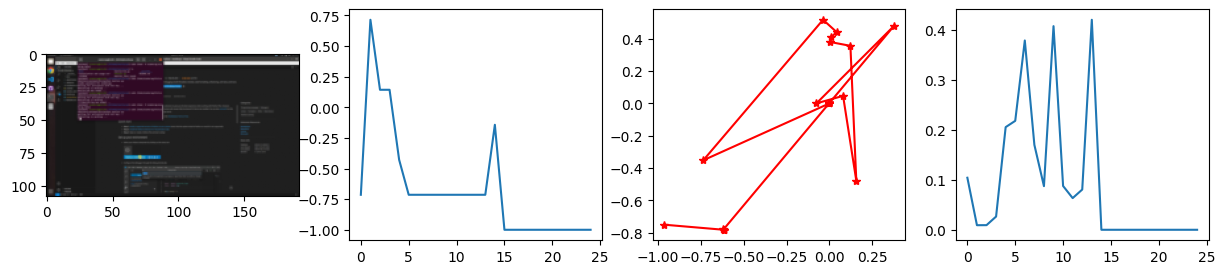

In [12]:
x0, (y1, y2, y3) = next(iter(valloader))
print(x0.shape, y1.shape, y2.shape, y3.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(15,3))
plt.subplot(141)
plt.imshow(x0[0,0,...].permute(1,2,0))
plt.subplot(142)
plt.plot(y1[0,:])
plt.subplot(143)
plt.plot(y2[0,:,0], y2[0,:,1], 'r-*')
plt.subplot(144)
plt.plot(y3[0,:,0])
plt.show()


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImgAttentionDiff(nn.Module):
    def __init__(self, patch_size, stride, d_dim):
        super().__init__()
        self.patch_size = patch_size
        self.d_dim = d_dim
        self.dh_dim = patch_size*patch_size*3
        self.patchify = nn.Unfold(kernel_size=patch_size, stride=stride)
        self.tokeys    = nn.Linear(self.dh_dim, d_dim, bias=False)
        self.toqueries = nn.Linear(self.dh_dim, d_dim, bias=False)
        self.gamma = 1.5 #nn.Parameter(3*torch.rand(1)+1.0)

    def forward(self, img_batch):
        x_tokens = self.patchify(img_batch).permute(0,2,1)
        Qd = self.toqueries(x_tokens)
        Kd = self.tokeys(x_tokens)  
        dot0 = torch.bmm(Qd, Kd.transpose(1, 2))
        dot1 = dot0/(self.d_dim**(1/2)) 
        dot2 = F.softmax(dot1, dim=2)
        raw_importance = dot2.sum(dim=1)

        mu_ones = torch.ones(raw_importance.shape)
        sigma = raw_importance.std(dim=1)[:,None].expand(raw_importance.shape)
        norm_importance = self.gamma*(raw_importance-mu_ones)/sigma
        selected_importance = F.softmax(norm_importance, dim=1)
        return selected_importance
        
class LSTM14_Attention(nn.Module):  
    def __init__(self, z_dim, h_dim, hfc_dim, patch_size, stride, d_dim, num_layers=1):
        super().__init__()
        self.imgattention = ImgAttentionDiff(patch_size, stride, d_dim)
        self.lstm = nn.LSTM(z_dim, h_dim, num_layers=num_layers, batch_first=True)
        self.fc1_action = nn.Linear(z_dim + h_dim, hfc_dim)
        self.fc2_action = nn.Linear(hfc_dim, 1)
        self.fc_position = nn.Linear(z_dim + h_dim, 2)
        self.fc_delay = nn.Linear(z_dim + h_dim, 1)

    def forward(self, img_sequence):  # both zt,ht as inputs
        patch_imp = self.imgattention(img_sequence)
        ht, _ = self.lstm(patch_imp)  # (N, L, h_dim)
        xt = torch.cat((patch_imp,ht), 2)
        at = self.fc2_action(F.relu(self.fc1_action(xt)))
        pt = self.fc_position(xt)
        dt = F.relu(self.fc_delay(xt))
        return at, pt, dt
    
mmm = LSTM14(z_dim=32, h_dim=256, hfc_dim=1024, num_layers=1)
out = mmm(x0)

print([out[i].shape for i in range(3)])


ValueError: LSTM: Expected input to be 2D or 3D, got 5D instead

In [15]:
mseloss = nn.MSELoss(reduction='mean')

def train_epoch(model, device, dataloader, optimizer):
    model.train()
    train_loss = 4*[0.0]
    for zt, (at, pt, dt) in dataloader: 
        zt = zt.to(device)
        at = at.to(device)
        pt = pt.to(device)
        dt = dt.to(device)

        at_pred, pt_pred, dt_pred = model(zt)
        la = mseloss(at_pred, at)
        lp = mseloss(pt_pred, pt)
        ld = mseloss(dt_pred, dt)
        loss = la + lp + ld

        model.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss[0]+=loss.item()
        train_loss[1]+=la.item()
        train_loss[2]+=lp.item()
        train_loss[3]+=ld.item()
    Ns = len(dataloader.dataset)
    return [iloss/Ns for iloss in train_loss]

def test_epoch(model, device, dataloader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): 
        for zt, (at, pt, dt)  in dataloader: 
            zt = zt.to(device)
            at = at.to(device)
            pt = pt.to(device)
            dt = dt.to(device)

            at_pred, pt_pred, dt_pred = model(zt)
            loss = mseloss(at_pred, at) + mseloss(pt_pred, pt) + mseloss(dt_pred, dt)
            val_loss += loss.item()
    return val_loss/len(dataloader.dataset)

In [16]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ezamorag (cic_lab). Use `wandb login --relogin` to force relogin


True

In [17]:
# Training from scratch
SEED = 0
lr = 0.01
epoch0 = 0
num_epochs = 500

torch.manual_seed(SEED)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'device: {device}')
#model = LSTM12(z_dim=32, h_dim=256, num_layers=1)
model = LSTM13(z_dim=32, h_dim=256, hfc_dim=1024, num_layers=1)
#model = LSTM14(z_dim=32, h_dim=256, hfc_dim=1024, num_layers=1)
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
best_valloss = float('Inf')
path_bestmodel = 'best_lstm13_vae.pt'

device: cuda


In [18]:
from IPython.display import clear_output

run = wandb.init(project="vae-pc", 
                 #name='2000 epochs', 
                 #entity='cic20',
                 mode="disabled", 
                 config={
                    "image_size": IMGSIZE,
                    "input_transform": img_transform, 
                    #"vae_latent_dims": d,
                    "learning_rate": lr,
                    "epochs": num_epochs,
                    "batch_size": trainloader.batch_size,
                    "seed": SEED, 
                 },
)
wandb.watch(model, log_freq=100)

trainloss, valloss = [], []
for epoch in range(epoch0, epoch0+num_epochs):
   trainloss.append(train_epoch(model,device,trainloader,optim))
   valloss.append(test_epoch(model,device,valloader))
   if valloss[-1] < best_valloss: 
      best_valloss = valloss[-1]
      torch.save({'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optim.state_dict(),
                  'trainloss': trainloss[-1][0],
                  'valloss': valloss[-1],},
                  path_bestmodel)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,trainloss[-1][0],valloss[-1]))
   print('\t\t action_loss {:.3f} \t position_loss {:.3f} \t pdelay_loss {:.3f}'.format(trainloss[-1][1],trainloss[-1][2],trainloss[-1][3]))
   #clear_output(wait=True) if (epoch + 1) % 10 == 0 else None
   wandb.log({"t_loss": trainloss[-1][0], "v_loss": valloss[-1]})


 EPOCH 1/500 	 train loss 0.170 	 val loss 0.237
		 action_loss 0.127 	 position_loss 0.038 	 pdelay_loss 0.005

 EPOCH 2/500 	 train loss 0.075 	 val loss 0.226
		 action_loss 0.038 	 position_loss 0.032 	 pdelay_loss 0.005

 EPOCH 3/500 	 train loss 0.088 	 val loss 0.327
		 action_loss 0.057 	 position_loss 0.027 	 pdelay_loss 0.004

 EPOCH 4/500 	 train loss 0.076 	 val loss 0.191
		 action_loss 0.044 	 position_loss 0.028 	 pdelay_loss 0.003

 EPOCH 5/500 	 train loss 0.086 	 val loss 0.224
		 action_loss 0.058 	 position_loss 0.024 	 pdelay_loss 0.004

 EPOCH 6/500 	 train loss 0.056 	 val loss 0.175
		 action_loss 0.030 	 position_loss 0.024 	 pdelay_loss 0.002

 EPOCH 7/500 	 train loss 0.068 	 val loss 0.163
		 action_loss 0.039 	 position_loss 0.025 	 pdelay_loss 0.003

 EPOCH 8/500 	 train loss 0.054 	 val loss 0.193
		 action_loss 0.029 	 position_loss 0.021 	 pdelay_loss 0.003

 EPOCH 9/500 	 train loss 0.069 	 val loss 0.178
		 action_loss 0.044 	 position_loss 0.022 	 p

best val_loss = 0.05479981750249863 at epoch = 304


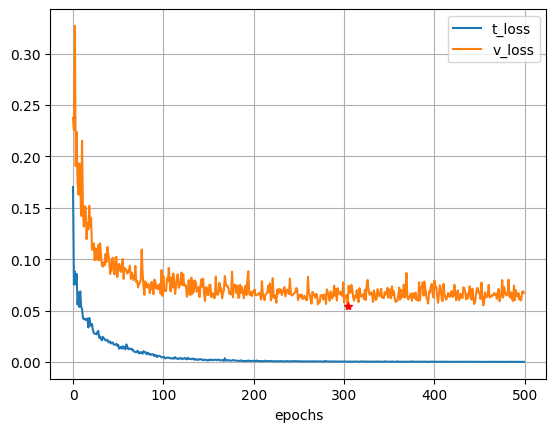

In [19]:
import numpy as np

ep_opt = np.argmin(np.asarray(valloss))
plt.plot([tloss for (tloss, _,_,_) in trainloss], label='t_loss')
plt.plot(valloss, label='v_loss')
plt.plot(ep_opt, valloss[ep_opt], 'r*')
plt.grid('on')
plt.xlabel('epochs')
plt.legend()
print(f'best val_loss = {valloss[ep_opt]} at epoch = {ep_opt}')
plt.show()

wandb.log({"best_val_loss": valloss[ep_opt], "best_epoch": ep_opt})

In [20]:
torch.save({'epoch': 499,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'trainloss': trainloss[-1],
            'valloss': valloss[-1],},
            'best_lstm13_vae_last.pt')

In [22]:
import numpy as np 

lstm_best = LSTM13(z_dim=32, h_dim=256, hfc_dim=1024, num_layers=1)
lstm_best.to(device)
lstm_best.load_state_dict(torch.load('best_lstm13_vae.pt')['model_state_dict'])

print(test_epoch(lstm_best,device,trainloader))
print(test_epoch(lstm_best,device,valloader))

# minimum val_loss
# LSTM12 - 0.0011959155090153217 0.061953626573085785
# LSTM13 - 0.0002495442284271121 0.06324800103902817  
# LSTM14 - 0.0007054965011775493 0.06297238916158676

0.0005002562887966633
0.06229288503527641


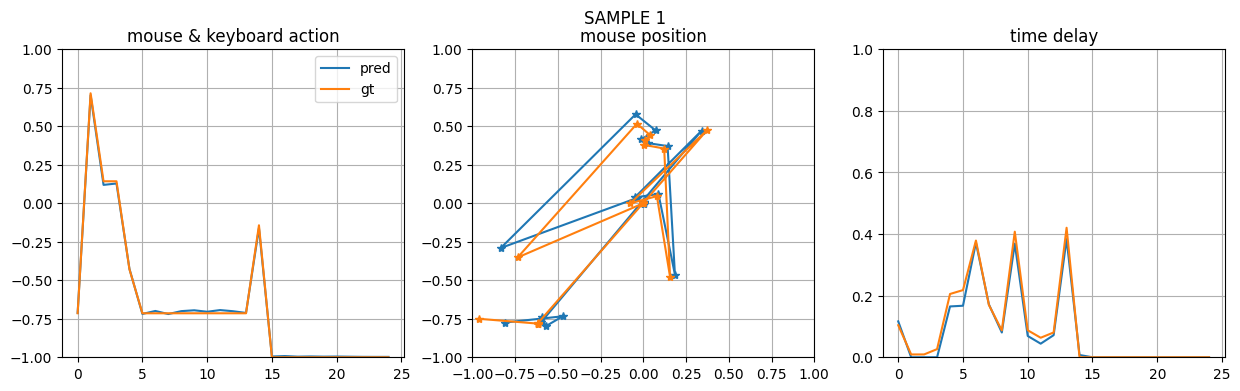

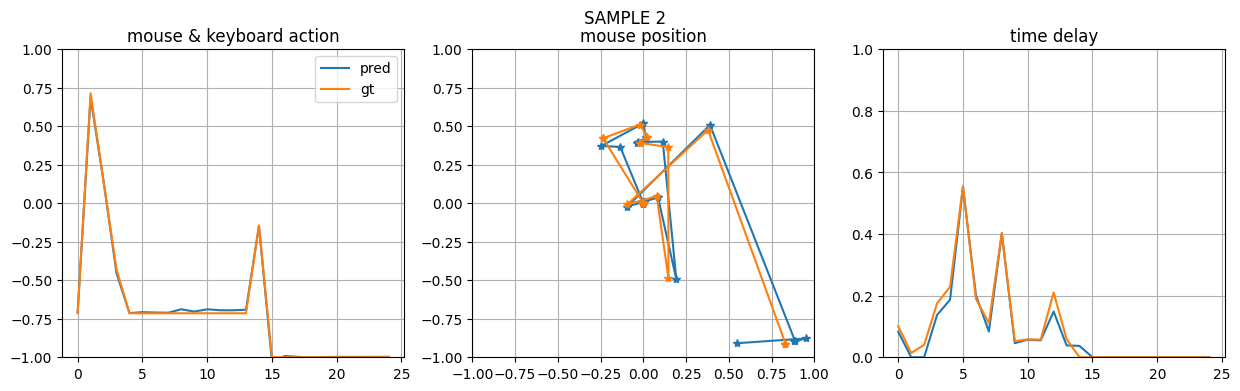

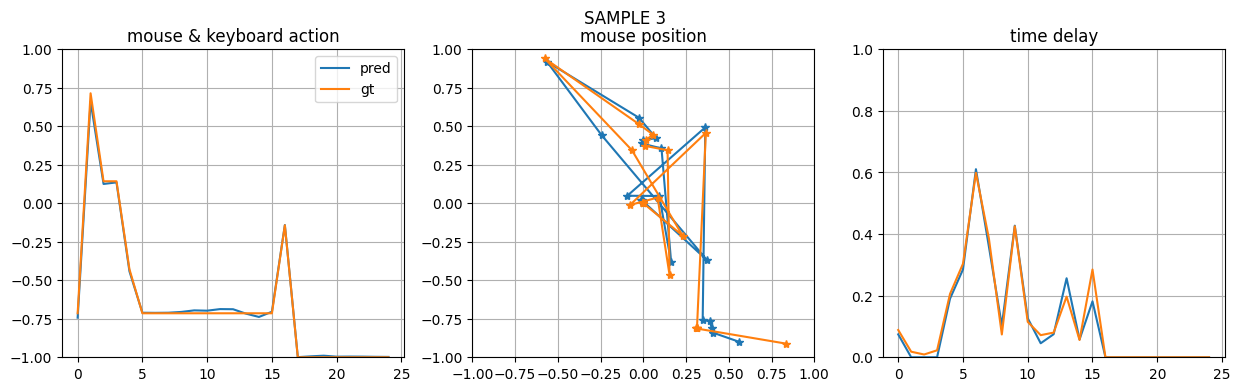

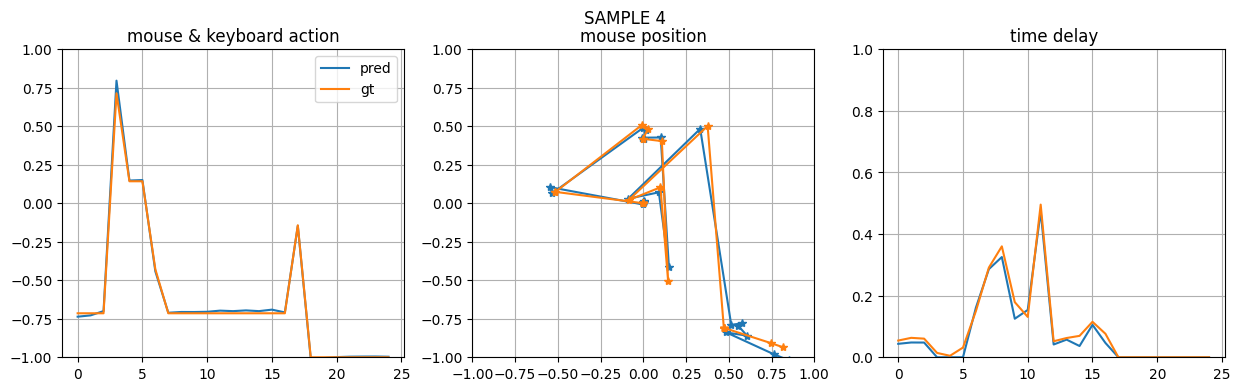

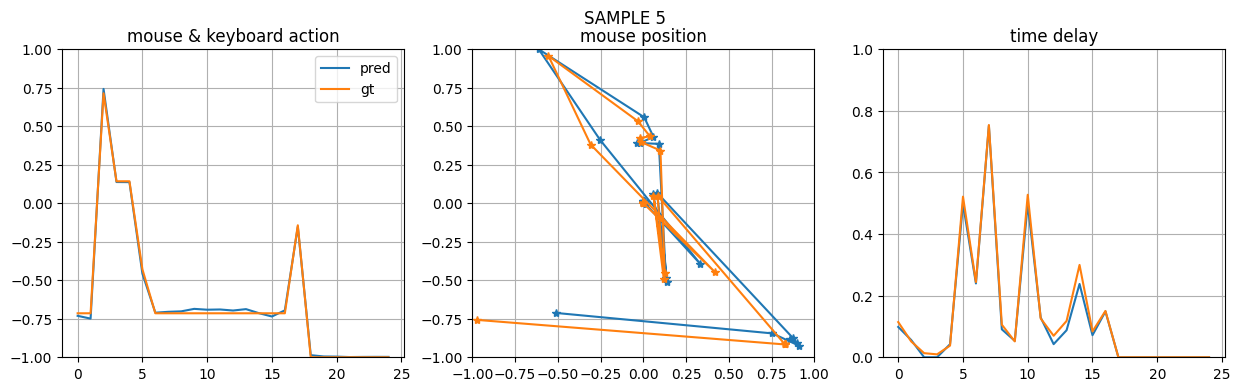

In [24]:
def viz(a, p, d, ib, label):
    a = a[ib].squeeze().detach().cpu().numpy()
    p = p[ib].squeeze().detach().cpu().numpy()
    d = d[ib].squeeze().detach().cpu().numpy()
    plt.suptitle(f'SAMPLE {ib+1}')
    plt.subplot(131)
    plt.plot(a, label=label)
    plt.ylim([-1,1])
    plt.grid("on")
    plt.title('mouse & keyboard action')
    plt.legend()
    plt.subplot(132)
    plt.plot(p[:,0], p[:,1], "-*", label=label)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.grid("on")
    plt.title('mouse position')
    plt.subplot(133)
    plt.plot(d, label=label)
    plt.ylim([0,1])
    plt.grid("on")
    plt.title('time delay')

with torch.no_grad():
    zb, (ab, pb, db) = next(iter(trainloader))

for ib in range(zb.shape[0]): 
    zb = zb.to(device)
    ab = ab.to(device)
    pb = pb.to(device)
    db = db.to(device)
    a_pred, p_pred, d_pred = lstm_best(zb)

    plt.figure(figsize=(15,4))
    viz(a_pred, p_pred, d_pred, ib, "pred")
    viz(ab, pb, db, ib, "gt")
    plt.show()

In [ ]:



def detransform(actions, max):
    actions = denormalization(actions, max)
    return np.round(actions).astype('uint8')

When a belief is deeply rooted in your mind, it is hard to overcome it. By a past machine learning course that I took in 2011, I learn that classification is easier than regression problem. Actualy, It is common practice to discritize the outputs of a regression problem in order to make it easier. Well, this rule seems to be broken using LSTM, particularly this is true for my pc cloner problem. I tried 